## Modeling

### Prophet Research

**Install Notes:**
- Numpy
  - Numpy is 1.23.0
  - scipy wants < 1.23.0
  - numba wants < 1.21
- daal4py
  - wants daal==2021.2.3 (which isn't installed)
- Plotly
  - may need to install to utilize some of the interactive figures

**DataFrame Prep:**
- Needs Pandas dataframe with 2 columns:
  - 'ds': datestamp that pandas recognizes
    - Says preferrably YYYY-MM-DD HH:MM:SS for timestamp, but hoping it takes time zone aware stuff
  - 'y': the target variable we want to forecast
    - if these are the only inputs, then I wonder if we can include temperatures :(
    
**Hyperparameters:**

- growth='linear'
  - Leave as linear since we don't have a market cap
- changepoints=None
  - Check out changepoints after first run or so
  - 1 person recommended 1 change point per month
  - but, this read almost like I could add a harvey thing in at first
- n_changepoints=25
- changepoint_range=0.8
- yearly_seasonality='auto'
- weekly_seasonality='auto'
- daily_seasonality='auto'
  - One recommendation was to set these to false then make our own
  - definitely want an hourly representation (which may really mean daily - as it repeats each day)
    - add seasonality probably with daily and fourier_order of 2-10 (probably on the lower side of that)
    - probably want something similar with the yearly - based off monthly plots, probably double whatever the appropriate hourly number should be
- holidays=None
  - NEEDS to be in hourly form
- seasonality_mode='additive'
  - stick with additive, but may want to check out a multiplicative
- seasonality_prior_scale=10.0
- holidays_prior_scale=10.0
  - try multiple values here.  
- changepoint_prior_scale=0.05
- mcmc_samples=0
- interval_width=0.8
- uncertainty_samples=1000
- stan_backend=None

**Cross_valdiation:**
- Parameters:
  - horizon: forecast time period (3 days?)
  - initial: initial training period (3 years? - minimum training window?)
  - period: spacing between cutoff dates
- Example:
  - from prophet.diagnostics import cross_validation
  - df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

  
    
**Regression:**
- Looks like we should be able to add weather data via add_regressors
  - Read up on [this article](https://towardsdatascience.com/forecast-model-tuning-with-additional-regressors-in-prophet-ffcbf1777dda)
  - Non-continuous variable: would need to bucket temperatures:
    - Maybe: is hot day? or is cold day?
    - Should this is hot/is cold be based on time of day?  would need to see inflection point for that


In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt

import wrangle

### Prophet Planning:

1. Create reshape dataframe function >> [jump to](#1)
2. Perform Basic Prophet model >> [jump to](#2) 
  - Use default 
  - Store performance variables
3. Add Prophet parameters >> [jump to](#3)
  - Holidays
  - Growth (ex: logistic) 
    - seems to be for market size info, probably inappropriate for us
    - want linear (default)
4. Perform Basic Prophet model w/ cross-validation
  - Use same parameters as #2
  - Add in cross-validation to get aggregated performance
  - sliding window if possible
5. Modify reshape function to add in a regressor

### 1) Create a reshape dataframe <a class='anchor' id='1'></a>

[Next](#2)

- need 'ds' column (start with UTC)
- need 'y' column (ercot load)

In [2]:
df = wrangle.get_combined_df()
df.index

DatetimeIndex(['2010-01-01 00:00:00-06:00', '2010-01-01 01:00:00-06:00',
               '2010-01-01 02:00:00-06:00', '2010-01-01 03:00:00-06:00',
               '2010-01-01 04:00:00-06:00', '2010-01-01 05:00:00-06:00',
               '2010-01-01 06:00:00-06:00', '2010-01-01 07:00:00-06:00',
               '2010-01-01 08:00:00-06:00', '2010-01-01 09:00:00-06:00',
               ...
               '2022-06-30 14:00:00-05:00', '2022-06-30 15:00:00-05:00',
               '2022-06-30 16:00:00-05:00', '2022-06-30 17:00:00-05:00',
               '2022-06-30 18:00:00-05:00', '2022-06-30 19:00:00-05:00',
               '2022-06-30 20:00:00-05:00', '2022-06-30 21:00:00-05:00',
               '2022-06-30 22:00:00-05:00', '2022-06-30 23:00:00-05:00'],
              dtype='datetime64[ns, US/Central]', name='datetime', length=109535, freq=None)

In [3]:
df.columns

Index(['ercot_load', 'dow', 'is_weekday', 'is_obs_holiday', 'hs_temp',
       'hs_feelslike', 'hs_dew', 'hs_humidity', 'hs_precip', 'hs_windgust',
       'hs_windspeed', 'hs_winddir', 'hs_sealevelpressure', 'hs_cloudcover',
       'hs_visibility', 'hs_solarradiation', 'hs_solarenergy', 'hs_uvindex',
       'gv_temp', 'gv_feelslike', 'gv_dew', 'gv_humidity', 'gv_precip',
       'gv_windgust', 'gv_windspeed', 'gv_winddir', 'gv_sealevelpressure',
       'gv_cloudcover', 'gv_visibility', 'gv_solarradiation', 'gv_solarenergy',
       'gv_uvindex', 'pl_temp', 'pl_feelslike', 'pl_dew', 'pl_humidity',
       'pl_precip', 'pl_windgust', 'pl_windspeed', 'pl_winddir',
       'pl_sealevelpressure', 'pl_cloudcover', 'pl_visibility',
       'pl_solarradiation', 'pl_solarenergy', 'pl_uvindex', 'vc_temp',
       'vc_feelslike', 'vc_dew', 'vc_humidity', 'vc_precip', 'vc_windgust',
       'vc_windspeed', 'vc_winddir', 'vc_sealevelpressure', 'vc_cloudcover',
       'vc_visibility', 'vc_solarradiation', '

In [4]:
prophet_df = pd.DataFrame()
prophet_df['ds'] = df.index.copy()
prophet_df['y'] = df.ercot_load.copy()

In [5]:
prophet_df

,ds,y
0,2010-01-01 00:00:00-06:00,NaN
1,2010-01-01 01:00:00-06:00,NaN
2,2010-01-01 02:00:00-06:00,NaN
3,2010-01-01 03:00:00-06:00,NaN
4,2010-01-01 04:00:00-06:00,NaN
...,...,...
109530,2022-06-30 19:00:00-05:00,NaN
109531,2022-06-30 20:00:00-05:00,NaN
109532,2022-06-30 21:00:00-05:00,NaN
109533,2022-06-30 22:00:00-05:00,NaN


In [6]:
#probably an index problem above, so instead:
df2 = pd.DataFrame(df.ercot_load)

In [7]:
df2 #now just need to move datetime to a column and relabel columns

,ercot_load
datetime,
2010-01-01 00:00:00-06:00,7931.241900
2010-01-01 01:00:00-06:00,7775.456846
2010-01-01 02:00:00-06:00,7704.815982
2010-01-01 03:00:00-06:00,7650.575724
2010-01-01 04:00:00-06:00,7666.708317
...,...
2022-06-30 19:00:00-05:00,15040.841510
2022-06-30 20:00:00-05:00,14700.132848
2022-06-30 21:00:00-05:00,14637.633680


In [8]:
df2.reset_index(drop=False, inplace=True)

In [9]:
df2.info() #cool, preserved tz aware datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109535 entries, 0 to 109534
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype                     
---  ------      --------------   -----                     
 0   datetime    109535 non-null  datetime64[ns, US/Central]
 1   ercot_load  109535 non-null  float64                   
dtypes: datetime64[ns, US/Central](1), float64(1)
memory usage: 1.7 MB


In [10]:
df2.rename(columns = {'datetime':'ds','ercot_load':'y'},inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109535 entries, 0 to 109534
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype                     
---  ------  --------------   -----                     
 0   ds      109535 non-null  datetime64[ns, US/Central]
 1   y       109535 non-null  float64                   
dtypes: datetime64[ns, US/Central](1), float64(1)
memory usage: 1.7 MB


###### Drop into a function

In [11]:
def get_prophet_df():
    '''
    Retrieves a cleaned dataframe and formats it for input into
    the FB Prophet model.
    
    NOTE: Prophet does not support timezone - need it in UTC, then make tz naive
    '''
    #Acquire combined dataframe
    df = wrangle.get_combined_df(get_central = False)
    #Pull index/load data into new 
    df2 = pd.DataFrame(df.ercot_load)
    #Move index out
    df2.reset_index(drop=False, inplace=True)
    #Rename columns
    df2.rename(columns = {'datetime':'ds','ercot_load':'y'},inplace=True)
    #Make TZ naive
    df2.ds = df2.ds.dt.tz_localize(None)
    
    return df2
    
    

In [12]:
test = get_prophet_df()

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109535 entries, 0 to 109534
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      109535 non-null  datetime64[ns]
 1   y       109535 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 MB


In [14]:
test.head(2)

,ds,y
0,2010-01-01 06:00:00,7931.241900
1,2010-01-01 07:00:00,7775.456846


### 2) Exploring the Basic Prophet Model <a class='anchor' id='2'></a>

In [15]:
df = wrangle.get_prophet_df()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109535 entries, 0 to 109534
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      109535 non-null  datetime64[ns]
 1   y       109535 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 MB


In [17]:
train = df[df.ds < '2018-01-01 06:00:00']
train

,ds,y
0,2010-01-01 06:00:00,7931.241900
1,2010-01-01 07:00:00,7775.456846
2,2010-01-01 08:00:00,7704.815982
3,2010-01-01 09:00:00,7650.575724
4,2010-01-01 10:00:00,7666.708317
...,...,...
70123,2018-01-01 01:00:00,12061.549401
70124,2018-01-01 02:00:00,12015.663549
70125,2018-01-01 03:00:00,11883.114122
70126,2018-01-01 04:00:00,11754.250889


In [18]:
from prophet import Prophet

In [19]:
help(Prophet)

Help on class Prophet in module prophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
 |      flat trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selec

In [20]:
model = Prophet()
type(model)

prophet.forecaster.Prophet

In [21]:
model.fit(train)

08:15:54 - cmdstanpy - INFO - Chain [1] start processing
08:16:18 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
#It doesn't let me pass in 0 periods for the future
#So instead, just grabbing 3 days
future = model.make_future_dataframe(periods=0,freq='H', include_history=True)
future

,ds
0,2010-01-01 06:00:00
1,2010-01-01 07:00:00
2,2010-01-01 08:00:00
3,2010-01-01 09:00:00
4,2010-01-01 10:00:00
...,...
70123,2018-01-01 01:00:00
70124,2018-01-01 02:00:00
70125,2018-01-01 03:00:00
70126,2018-01-01 04:00:00


In [23]:
#Let's see the forecast for the last 3 days
per3 = 24*3
per365 = 24*365
forecast3 = model.predict(future[-per3:])
forecast = model.predict(future[-per365:])
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
8755,2018-01-01 01:00:00,12098.657955,10223.413036,13296.512326,12098.657955,12098.657955,-405.646100,-405.646100,-405.646100,1347.131732,...,-424.960641,-424.960641,-424.960641,-1327.817191,-1327.817191,-1327.817191,0.0,0.0,0.0,11693.011854
8756,2018-01-01 02:00:00,12098.688428,9892.224258,13113.600592,12098.688428,12098.688428,-591.519098,-591.519098,-591.519098,1124.830350,...,-389.541322,-389.541322,-389.541322,-1326.808126,-1326.808126,-1326.808126,0.0,0.0,0.0,11507.169330
8757,2018-01-01 03:00:00,12098.718902,9747.180226,12754.149490,12098.718902,12098.718902,-943.120947,-943.120947,-943.120947,735.894212,...,-353.215655,-353.215655,-353.215655,-1325.799504,-1325.799504,-1325.799504,0.0,0.0,0.0,11155.597955
8758,2018-01-01 04:00:00,12098.749375,9147.871752,12211.207220,12098.749375,12098.749375,-1485.064549,-1485.064549,-1485.064549,155.954187,...,-316.227373,-316.227373,-316.227373,-1324.791363,-1324.791363,-1324.791363,0.0,0.0,0.0,10613.684827
8759,2018-01-01 05:00:00,12098.779849,8340.458559,11433.075229,12098.779849,12098.779849,-2148.727872,-2148.727872,-2148.727872,-546.122695,...,-278.821435,-278.821435,-278.821435,-1323.783743,-1323.783743,-1323.783743,0.0,0.0,0.0,9950.051977


**Plot Method Notes**

plot(self, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y', figsize=(10, 6), include_legend=False)
 - Plot the Prophet forecast.

**Parameters**


 - fcst: pd.DataFrame output of self.predict.
 - ax: Optional matplotlib axes on which to plot.
 - uncertainty: Optional boolean to plot uncertainty intervals.
 - plot_cap: Optional boolean indicating if the capacity should be shown in the figure, if available.
 - xlabel: Optional label name on X-axis
 - ylabel: Optional label name on Y-axis
 - figsize: Optional tuple width, height in inches.
 - include_legend: Optional boolean to add legend to the plot.

----------
**Returns**
 - A matplotlib figure.

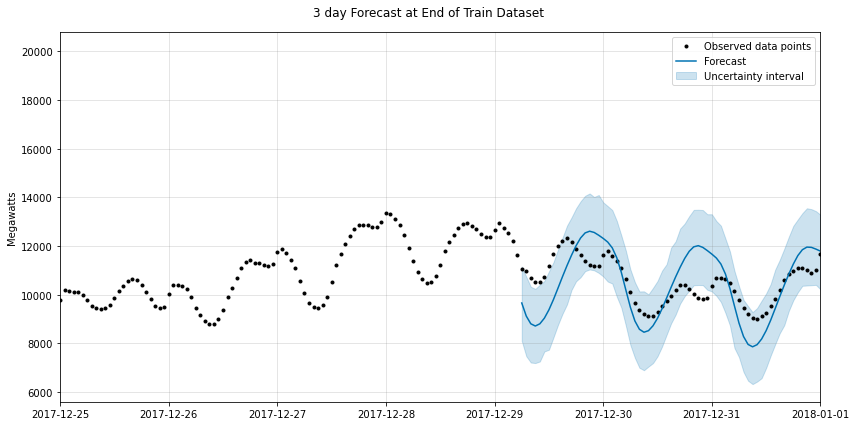

In [24]:
#plot the forecast
fig = model.plot(forecast3,xlabel=None,ylabel='Megawatts',include_legend=True,figsize=(12,6))
fig.suptitle('3 day Forecast at End of Train Dataset')
ax = fig.gca()
#filter to last week
ax.set_xlim((datetime.date(2017,12,25),datetime.date(2018,1,1)));
plt.tight_layout()

<div class="alert alert-info"><b>MODELING NOTES:</b> 
<ul>
    <li>This is clearly not making use of the most recent part of the time series to inform the predictions.  <b>ACTUALLY - it seems to be using the last time and forecasting backwards!</b></li>
    <li>It also seems to be doing a lower fourier_order than what appears to be needed for this daily section.  However, that is a nonstandard day pattern according to our exploration plots of daily load.  Can I pull out the seasonality settings for this model?</li>
    </ul></div>


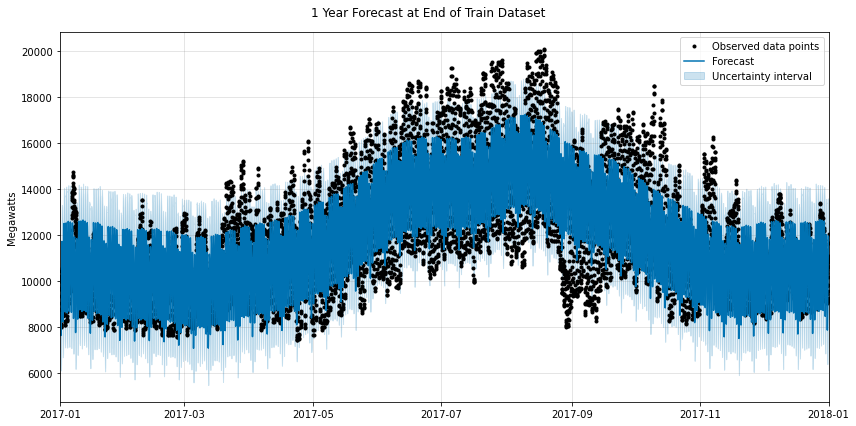

In [25]:
#Let's look at the last year to see how that trend goes
fig = model.plot(forecast,xlabel=None,ylabel='Megawatts',include_legend=True,figsize=(12,6))
fig.suptitle('1 Year Forecast at End of Train Dataset')
ax = fig.gca()
#filter to last week
ax.set_xlim((datetime.date(2017,1,1),datetime.date(2018,1,1)));
plt.tight_layout()

**plot_components method documentation**

plot_components(self, fcst, uncertainty=True, plot_cap=True, weekly_start=0, yearly_start=0, figsize=None)
- Plot the Prophet forecast components. Will plot whichever are available of: trend, holidays, weekly seasonality, and yearly seasonality.
----------
**Parameters**

- fcst: pd.DataFrame output of self.predict.
- uncertainty: Optional boolean to plot uncertainty intervals.
- plot_cap: Optional boolean indicating if the capacity should be shown in the figure, if available.
- weekly_start: Optional int specifying the start day of the weekly  seasonality plot. 0 (default) starts the week on Sunday. 1 shifts by 1 day to Monday, and so on.
- yearly_start: Optional int specifying the start day of the yearly seasonality plot. 0 (default) starts the year on Jan 1. 1 shifts by 1 day to Jan 2, and so on.
- figsize: Optional tuple width, height in inches.
----------
**Returns**
- A matplotlib figure.

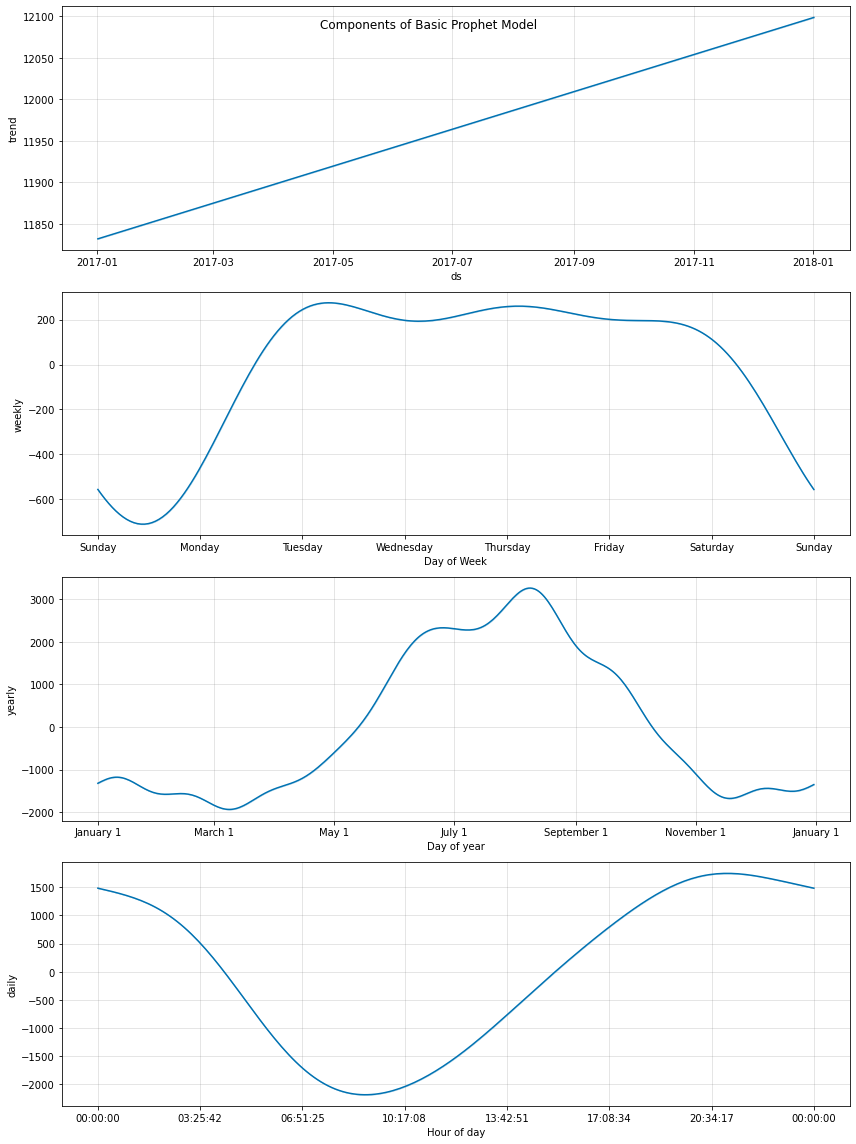

In [32]:
#That looks TERRIBLE, instead plot the seasonal components
fig = model.plot_components(forecast,plot_cap=False,figsize=(12,16))
fig.suptitle('Components of Basic Prophet Model');

In [26]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None}),
             ('weekly',
              {'period': 7,
               'fourier_order': 3,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None}),
             ('daily',
              {'period': 1,
               'fourier_order': 4,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

<div class="alert alert-info"><b>SEASONALITY NOTES:</b> 
<ul>
    <li>The daily fourier_order of 4 seems insufficient, so we may want to increase that. HOWEVER, this may be a product of other parts of the year exhibiting a lower order.  Once we add holidays, this may change. </li>
    <li>The yearly fourier_order of 10 seems overweight.  LIkely overfitting.  Once we add regressors, we may also want to reduce the scale on this.</li>
    <li>The weekly order of 3 seems too low.  It may also be because of the transition though.  Having a curve here </li>
    </ul></div>

<div class="alert alert-warning"><b>CHANGE IN PLAN:</b> 
<ul>
    <li>Is suspect the use of cross-validation will remove the start point problems I saw in the 3 day forecast.  <b>Switching to add cross-validation next</b></li>
    <li>After cross-validation, I will <b>redo the seasonality work</b>, then make decisions on hyperparameters</li>
    <li>Lastly, I need to get some <b>model performance stats</b> and dig into that.</li>
    </ul></div>

### Cross Validation

In [34]:
from prophet.diagnostics import cross_validation

In [35]:
help(cross_validation)

Help on function cross_validation in module prophet.diagnostics:

cross_validation(model, horizon, period=None, initial=None, parallel=None, cutoffs=None, disable_tqdm=False)
    Cross-Validation for time series.
    
    Computes forecasts from historical cutoff points, which user can input.
    If not provided, begins from (end - horizon) and works backwards, making
    cutoffs with a spacing of period until initial is reached.
    
    When period is equal to the time interval of the data, this is the
    technique described in https://robjhyndman.com/hyndsight/tscv/ .
    
    Parameters
    ----------
    model: Prophet class object. Fitted Prophet model.
    horizon: string with pd.Timedelta compatible style, e.g., '5 days',
        '3 hours', '10 seconds'.
    period: string with pd.Timedelta compatible style. Simulated forecast will
        be done at every this period. If not provided, 0.5 * horizon is used.
    initial: string with pd.Timedelta compatible style. The first tra